# Machine Learning - HR Analytics: Job Change of Data Scientists

## Setup

In [1]:
import os
from pprint import pprint 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.formula.api as smf

plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import recall_score,precision_score,f1_score, ConfusionMatrixDisplay,roc_auc_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
HR_ANALYSIS_PATH = os.path.join("../input/aug_train.csv")

## Import Data

In [4]:
# Import data
data = pd.read_csv(HR_ANALYSIS_PATH)
data.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


In [5]:
data.shape

(19158, 14)

### Handle Missing Values

gender has 3410 (23.7%) missing values Missing > Keep as new category "not_specified"

major_discipline has 2105 (14.7%) missing values + imbalanced > SKIP!

company_size has 4475 (31.1%) missing values > Keep as new category "not_specified"

company_type has 4628 (32.2%) missing value + imbalanced > SKIP!

major_discipline > imbalanced > SKIP!

In [6]:
values = {'gender': 'not_specified', 'company_size': 'not_specified'}
data = data.fillna(value = values)
data.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,not_specified,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,not_specified,No relevent experience,Full time course,Graduate,STEM,5,not_specified,NaN,never,83,0.0


In [7]:
# Check for duplicate rows
duplicateRows = data[data.duplicated(['enrollee_id'])]
duplicateRows

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target


## Train Test Split

In [8]:
df_train, df_test = train_test_split(data, random_state=42)

In [9]:
X_train = df_train.drop(columns=['target']) # independant features
y_train = df_train['target'] # dependant variable

In [10]:
df_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
3063,1426,city_16,0.910,not_specified,No relevent experience,no_enrollment,Graduate,Humanities,<1,50-99,Pvt Ltd,1,72,0.0
11518,20023,city_111,0.698,not_specified,Has relevent experience,Full time course,Graduate,STEM,7,500-999,NGO,1,8,0.0
5665,11714,city_100,0.887,not_specified,No relevent experience,Full time course,Graduate,STEM,6,not_specified,NaN,never,42,1.0


In [11]:
df_train.shape

(14368, 14)

In [12]:
df_test.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
16144,6992,city_16,0.910,not_specified,Has relevent experience,no_enrollment,Graduate,STEM,6,500-999,Pvt Ltd,1,21,0.0
13661,8637,city_103,0.920,Female,Has relevent experience,no_enrollment,Masters,Humanities,>20,100-500,Funded Startup,2,74,0.0
344,24729,city_104,0.924,not_specified,Has relevent experience,no_enrollment,Graduate,STEM,9,10/49,Pvt Ltd,1,94,0.0


In [13]:
df_test.shape

(4790, 14)

In [14]:
#X_train.head(3)

In [15]:
X_train.shape

(14368, 13)

In [16]:
y_train.shape

(14368,)

## Transformation Train Data

### Transformation pipeline 1 

- Simple Imputer (numeric and categorical values)

- StandardScaler (numeric values)

- OneHotEncoder (categorical values)

In [17]:
df_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
3063,1426,city_16,0.910,not_specified,No relevent experience,no_enrollment,Graduate,Humanities,<1,50-99,Pvt Ltd,1,72,0.0
11518,20023,city_111,0.698,not_specified,Has relevent experience,Full time course,Graduate,STEM,7,500-999,NGO,1,8,0.0
5665,11714,city_100,0.887,not_specified,No relevent experience,Full time course,Graduate,STEM,6,not_specified,NaN,never,42,1.0


In [18]:
# categorical values:
cat_cols1 = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
            'experience', 'company_size', 'company_type', 'last_new_job']
# numeric values:
num_cols1 = ['city_development_index', 'training_hours']

# target values:
target_col = 'target'

In [19]:
num_pipeline1 = Pipeline([
    ("simple_imp", SimpleImputer()),
    ("std_scaler", StandardScaler())
])

In [20]:
cat_pipeline1 = Pipeline([
    ("simple_imp", SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', fill_value=str)),
    ("one_hot", OneHotEncoder(sparse= False, handle_unknown='ignore'))
])

In [21]:
# Pipeline 1:
pipeline1 = ColumnTransformer([
    ("num", num_pipeline1, num_cols1),
    ("cat", cat_pipeline1, cat_cols1),
], sparse_threshold=0)

# OneHotEncoder cannot deal with missing values > so SimpleImputer is first
# Drop=None (default) to keep all columns for decision tree analysis (‘dummy variable trap’)
# sparse= False to receive a dense array output
set_config(display="diagram")
pipeline1

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['city_development_index', 'training_hours']),
                                ('cat',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer(fill_value=<class 'str'>,
                                                                strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['city', 'gender', 'relevent_experience',
                                  'enrolled_university', 'education_level',
                                  'experience', 'company_size', 'company_type',
                                  'last_new_job'])])

In [22]:
X1 = pipeline1.fit_transform(df_train)
X1.shape

(14368, 181)

In [23]:
pd.DataFrame(X1).head(3)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.659208,0.115908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.062355,-0.955336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.472435,-0.386238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Transformation pipeline 2

- Simple Imputer (numeric and categorical values)

- MinMaxScaler (numeric values)

- OneHotEncoder (categorical values)

In [24]:
# categorical values:
cat_cols2 = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
            'experience', 'company_size', 'company_type', 'last_new_job']
# numeric values:
num_cols2 = ['city_development_index', 'training_hours']

# target values:
target_col = 'target'

In [25]:
num_pipeline2 = Pipeline([
    ("simple_imp", SimpleImputer()),
    ("min_max", MinMaxScaler())
])

In [26]:
cat_pipeline2 = Pipeline([
    ("simple_imp", SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', fill_value=str)),
    ("one_hot", OneHotEncoder(sparse= False, handle_unknown='ignore'))
])

In [27]:
# Pipeline 2:
pipeline2 = ColumnTransformer([
    ("num", num_pipeline2, num_cols2),
    ("cat", cat_pipeline2, cat_cols2),
], sparse_threshold=0)

pipeline2

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer()),
                                                 ('min_max', MinMaxScaler())]),
                                 ['city_development_index', 'training_hours']),
                                ('cat',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer(fill_value=<class 'str'>,
                                                                strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['city', 'gender', 'relevent_experience',
                                  'enrolled_university', 'education_level',
                                  'experience', 'company_size', 'company_type',
                                  'last_new_job'])])

In [28]:
X2 = pipeline2.fit_transform(df_train)
X2.shape

(14368, 181)

In [29]:
pd.DataFrame(X2).head(3)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.922156,0.211940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.499002,0.020896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.876248,0.122388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Transformation pipeline 3 

- drop column 'company_type' (over 20% missing values) and 'enrollee_id'

- Simple Imputer (numeric and categorical values)

- MinMaxScaler (numeric and categorical values)

- OneHotEncoder (selected categorical values)

- OrdinalEncoder (selected categorical values)

In [30]:
# categorical values:
cat_cols3_onehot = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'major_discipline']

cat_cols3_ordinal  = ['education_level', 'company_size', 'last_new_job', 'experience']

# numeric values:
num_cols3 = ['city_development_index', 'training_hours']

# target values:
target_col = 'target'

In [31]:
mapping = [{
    "col":"education_level", "mapping": {
        'Primary School':1, 
        'High School':2, 
        'Graduate':3, 
        'Masters':4, 
        'Phd':5, 
    }},
    {
    "col":"company_size", "mapping": {
        '<10':1, 
        '10/49':2, 
        '50-99':3, 
        '100-500':4, 
        '500-999':5, 
        '1000-4999':6,
        '5000-9999':7,
        '10000+':8,
        'not_specified':9
    }},
    {
    "col":"last_new_job", "mapping": {
        'never':1, 
        '1':2, 
        '2':3, 
        '3':4, 
        '4':5, 
        '>4':6
    }},
    {
    "col":"experience", "mapping": {
        '<1':1, 
        '1':2, 
        '2':3, 
        '3':4, 
        '4':5, 
        '5':6,
        '6':7, 
        '7':8, 
        '8':9, 
        '9':10, 
        '10':11,
        '11':12, 
        '12':13, 
        '13':14, 
        '14':15, 
        '15':16,
        '16':17, 
        '17':18, 
        '18':19, 
        '19':20, 
        '20':21, 
        '>20':22
          }}
]

In [32]:
num_pipeline3 = Pipeline([
    ("simple_imp", SimpleImputer()),
    ("min_max", MinMaxScaler())
])

In [33]:
onehot_pipeline3 = Pipeline([
    ("simple_imp", SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', fill_value=str)),
    ("one_hot", OneHotEncoder(sparse= False, handle_unknown='ignore'))
])

In [34]:
ordinal_pipeline3 = Pipeline([
    ("ordinal", ce.OrdinalEncoder(mapping=mapping,  handle_missing='return_nan')),
    ("simple_imp", SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', fill_value=str)),
    ("min_max", MinMaxScaler())
])

In [35]:
# Pipeline 3:
pipeline3 = ColumnTransformer([
    ("num", num_pipeline3, num_cols3),
    ("onehot", onehot_pipeline3, cat_cols3_onehot),
    ("ordinal", ordinal_pipeline3, cat_cols3_ordinal)
], sparse_threshold=0)

pipeline3

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer()),
                                                 ('min_max', MinMaxScaler())]),
                                 ['city_development_index', 'training_hours']),
                                ('onehot',
                                 Pipeline(steps=[('simple_imp',
                                                  SimpleImputer(fill_value=<class 'str'>,
                                                                strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),...
                                                                          {'col': 'experience',
                                                                           'mapping': {'1': 2,
                                                                                       '10': 11,
                                                                                       '11': 12,
                                                                                       '12': 13,
                                                                                       '13': 14,
                                                                                       '14': 15,
                                                                                       '15': 16,
                                                                                       '16': 17,
                                                                                       '17': 18,
                                                                                       '18': 19,
                                                                                       '19': 20,
                                                                                       '2': 3,
                                                                                       '20': 21,
                                                                                       '3': 4,
                                                                                       '4': 5,
                                                                                       '5': 6,
                                                                                       '6': 7,
                                                                                       '7': 8,
                                                                                       '8': 9,
                                                                                       '9': 10,
                                                                                       '<1': 1,
                                                                                       '>20': 22}}])),
                                                 ('simple_imp',
                                                  SimpleImputer(fill_value=<class 'str'>,
                                                                strategy='most_frequent')),
                                                 ('min_max', MinMaxScaler())]),
                                 ['education_level', 'company_size',
                                  'last_new_job', 'experience'])])

In [36]:
X3 = pipeline3.fit_transform(df_train)
X3.shape

(14368, 143)

In [37]:
pd.DataFrame(X3).head(3)

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,0.922156,0.211940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.25,0.428571,0.086957
1,0.499002,0.020896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.50,0.428571,0.391304
2,0.876248,0.122388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,1.00,0.285714,0.347826


### Zielvariable y

In [38]:
# Zielvariable:
y = df_train[target_col]
y.shape

(14368,)

### Zielvariable y_smote (Oversampling Target)

In [39]:
X1.shape, y.shape, df_train.shape

((14368, 181), (14368,), (14368, 14))

In [40]:
oversample = SMOTE(random_state=42)

In [41]:
X1_smote, y1_smote = oversample.fit_resample(X1, y)
X1_smote.shape, y1_smote.shape, df_train.shape

((21594, 181), (21594,), (14368, 14))

In [42]:
count_1=0
count_0=0
for i in y1_smote:
    if int(i)==1:
        count_1+=1
    else:
        count_0+=1
print('The number of 1 in the target now are: ',count_1)
print('The number of 0 in the target now are: ',count_0)

The number of 1 in the target now are:  10797
The number of 0 in the target now are:  10797


After oversampling, we see an equal distribution of candidates seeking a job change and those who are not looking for a new job.

In [43]:
X2_smote, y2_smote = oversample.fit_resample(X2, y)
X2_smote.shape, y2_smote.shape, df_train.shape

((21594, 181), (21594,), (14368, 14))

In [44]:
X3_smote, y3_smote = oversample.fit_resample(X3, y)
X3_smote.shape, y3_smote.shape, df_train.shape

((21594, 143), (21594,), (14368, 14))

## Transformation Test Data

In [45]:
df_test.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
16144,6992,city_16,0.910,not_specified,Has relevent experience,no_enrollment,Graduate,STEM,6,500-999,Pvt Ltd,1,21,0.0
13661,8637,city_103,0.920,Female,Has relevent experience,no_enrollment,Masters,Humanities,>20,100-500,Funded Startup,2,74,0.0
344,24729,city_104,0.924,not_specified,Has relevent experience,no_enrollment,Graduate,STEM,9,10/49,Pvt Ltd,1,94,0.0


In [46]:
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [47]:
# Transformation pipeline1
X1_test = pipeline1.transform(df_test)
X1_test.shape

(4790, 181)

In [48]:
# Transformation pipeline2
X2_test = pipeline2.transform(X_test)
X2_test.shape

(4790, 181)

In [49]:
# Transformation pipeline3
X3_test = pipeline3.transform(X_test)
X3_test.shape

(4790, 143)

## Analysis

### Comparsion Transformations - LogisticRegression 

#### Scoring LogisticRegression

In [50]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X1, y_train)
m.score(X1, y)

0.7875835189309577

In [51]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X2, y_train)
m.score(X2, y)

0.7876531180400891

In [52]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X3, y_train)
m.score(X3, y)

0.777978841870824

#### Scoring LogisticRegression including Oversampling

In [53]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X1_smote, y1_smote)
m.score(X1_smote, y1_smote)

0.7822080207465036

In [54]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X2_smote, y2_smote)
m.score(X2_smote, y2_smote)

0.7837362230249143

In [55]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
m = logreg.fit(X3_smote, y3_smote)
m.score(X3_smote, y3_smote)

0.7479392423821432

### Comparsion Transformations - Decision Tree Classifier

#### Scoring Decision Tree Classifier

max_depth=2

In [56]:
dtclass2 = DecisionTreeClassifier(max_depth=2)
m1 = dtclass2.fit(X1, y_train)
m1.score(X1, y)

0.7858435412026726

In [57]:
dtclass2 = DecisionTreeClassifier(max_depth=2)
m2 = dtclass2.fit(X2, y_train)
m2.score(X2, y)

0.7858435412026726

In [58]:
dtclass2 = DecisionTreeClassifier(max_depth=2)
m3 = dtclass2.fit(X3, y_train)
m3.score(X3, y)

0.7858435412026726

max_depth=3

In [59]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m4 = dtclass3.fit(X1, y_train)
m4.score(X1, y)

0.7864003340757239

In [60]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m5 = dtclass3.fit(X2, y_train)
m5.score(X2, y)

0.7864003340757239

In [61]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m6 = dtclass3.fit(X3, y_train)
m6.score(X3, y)

0.7858435412026726

max_depth=4

In [62]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m7 = dtclass4.fit(X1, y_train)
m7.score(X1, y)

0.7867483296213809

In [63]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m8 = dtclass4.fit(X2, y_train)
m8.score(X2, y)

0.7867483296213809

In [64]:
dtclass4 = DecisionTreeClassifier(max_depth=4)  #best result so far
m9 = dtclass4.fit(X3, y_train)
m9.score(X3, y)

0.7932906458797327

#### Scoring Decision Tree Classifier including Oversampling

max_depth=3

In [65]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m4 = dtclass3.fit(X1_smote, y1_smote)
m4.score(X1_smote, y1_smote)

0.7742891543947393

In [66]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m5 = dtclass3.fit(X2_smote, y2_smote)
m5.score(X2_smote, y2_smote)

0.7733166620357507

In [67]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
m6 = dtclass3.fit(X3_smote, y3_smote)
m6.score(X3_smote, y3_smote)

0.7724367879966657

max_depth=4

In [68]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m7 = dtclass4.fit(X1_smote, y1_smote)
m7.score(X1_smote, y1_smote)

0.784986570343614

In [69]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m8 = dtclass4.fit(X2_smote, y2_smote)
m8.score(X2_smote, y2_smote)

0.7848013337038066

In [70]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m9 = dtclass4.fit(X3_smote, y3_smote)
m9.score(X3_smote, y3_smote)

0.7740112994350282

#### Findings
- No improvement could be achieved by oversampling the data.
- Of the models tested, the Decision Tree Classifier with max_depth=4 on Pipeline 3 gives the best results. (Score: 0.7933)


## Review

### Applying Models / Model Scores
> DecisionTreeClassifier

> RandomForestClassifier

> LogisticRegression

In [71]:
for i in [1, 3, 4, 5, 6, 7, 8]:
    print()
    print("i=%s" % i)
    print()
    for p_num, pipe in [(1, pipeline1), (2, pipeline2), (3, pipeline3)]:
        m = DecisionTreeClassifier(max_depth=i).fit(pipe.fit_transform(df_train), y_train)
        print("Pipeline:", p_num, "DecisionTree:", round(m.score(pipe.transform(df_train), y_train), 4), "vs", round(m.score(pipe.transform(df_test), y_test), 4))
        
        m = RandomForestClassifier(max_depth=i).fit(pipe.transform(df_train), y_train)
        print("Pipeline:", p_num, "RandomForest:", round(m.score(pipe.transform(df_train), y_train), 4), "vs", round(m.score(pipe.transform(df_test), y_test), 4))
        
        m = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42).fit(pipe.transform(df_train), y_train)
        print("Pipeline:", p_num, "LogisticRegression:", round(m.score(pipe.fit_transform(df_train), y_train), 4), "vs", round(m.score(pipe.transform(df_test), y_test), 4))
      


i=1

Pipeline: 1 DecisionTree: 0.7858 vs 0.7718
Pipeline: 1 RandomForest: 0.7515 vs 0.7482
Pipeline: 1 LogisticRegression: 0.7876 vs 0.7758
Pipeline: 2 DecisionTree: 0.7858 vs 0.7718
Pipeline: 2 RandomForest: 0.7515 vs 0.7482
Pipeline: 2 LogisticRegression: 0.7877 vs 0.7758
Pipeline: 3 DecisionTree: 0.7858 vs 0.7718
Pipeline: 3 RandomForest: 0.7515 vs 0.7482
Pipeline: 3 LogisticRegression: 0.778 vs 0.7643

i=3

Pipeline: 1 DecisionTree: 0.7864 vs 0.7724
Pipeline: 1 RandomForest: 0.7515 vs 0.7482
Pipeline: 1 LogisticRegression: 0.7876 vs 0.7758
Pipeline: 2 DecisionTree: 0.7864 vs 0.7724
Pipeline: 2 RandomForest: 0.7515 vs 0.7482
Pipeline: 2 LogisticRegression: 0.7877 vs 0.7758
Pipeline: 3 DecisionTree: 0.7858 vs 0.7718
Pipeline: 3 RandomForest: 0.7515 vs 0.7482
Pipeline: 3 LogisticRegression: 0.778 vs 0.7643

i=4

Pipeline: 1 DecisionTree: 0.7867 vs 0.7714
Pipeline: 1 RandomForest: 0.7517 vs 0.7484
Pipeline: 1 LogisticRegression: 0.7876 vs 0.7758
Pipeline: 2 DecisionTree: 0.7867 vs 0.7

**Best Models:**
- Pipeline: 3 DecisionTree, i=6: Training Score 0.8035 vs Test Score 0.7891
- Pipeline: 2 DecisionTree, i=7: Training Score 0.8050 vs Test Score 0.7852

### GridSearch / Confusion Matrix

**True Positives** 
These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.  

**True Negatives** 
These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.  


False positives and false negatives, these values occur when your actual class contradicts with the predicted class.  

**False Positives**
When actual class is no and predicted class is yes.  

**False Negatives**   
When actual class is yes but predicted class in no.  



**Precision**
The precision is calculated as the ratio between the number of Positive samples correctly classified to the total number of samples classified as Positive (either correctly or incorrectly). The precision measures the model's accuracy in classifying a sample as positive.

**Recall**
The recall is calculated as the ratio between the number of Positive samples correctly classified as Positive to the total number of Positive samples. The recall measures the model's ability to detect Positive samples. The higher the recall, the more positive samples detected.

**Precision or Recall?**
The decision of whether to use precision or recall depends on the type of problem being solved. If the goal is to detect all the positive samples (without caring whether negative samples would be misclassified as positive), then use recall. Use precision if the problem is sensitive to classifying a sample as Positive in general, i.e. including Negative samples that were falsely classified as Positive.

For the question we are looking at here, recall is the best measure to describe the quality of the forecast. We want to find as many candidates as possible who are open to changing jobs.  If some candidates are classified as willing to change jobs who are not, this is a comparatively smaller problem than not finding possible new employees for the company.

#### DecisionTreeClassifier / Pipeline 2

{'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 14, 'random_state': 42}
Accuracy score : 0.75
Recall score : 0.57
Precision score : 0.01
F1 score : 0.03


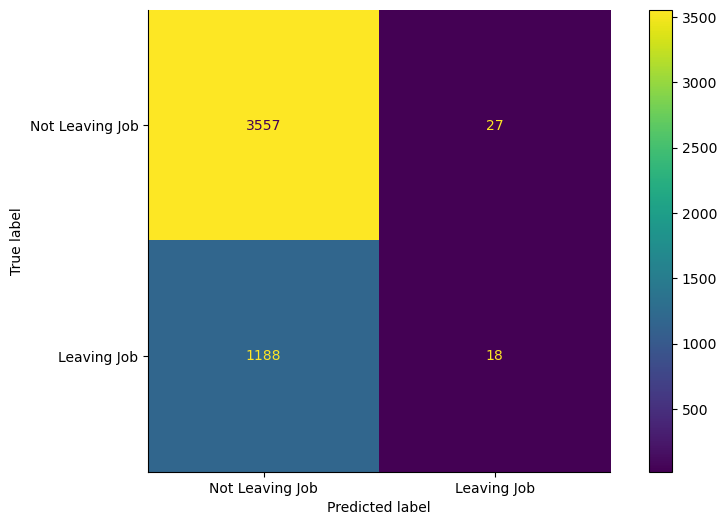

In [72]:
GridSearch = True
if GridSearch == True:
    param_grid = {'max_features': [2,3,4,5], 'max_depth':[5,6,7], 'min_samples_leaf':[8,9,10,11,12,13,14],'random_state':[1,42] } 
    dt = DecisionTreeClassifier()
    dt_cv =  GridSearchCV(dt, param_grid)
    dt_cv.fit(X2, y)
    print(dt_cv.best_params_)
    dtpre = dt_cv.predict(X2_test)
    dtcm = confusion_matrix(y_test,dtpre)
    print("Accuracy score : {:.2f}".format(accuracy_score(dtpre,y_test)))
    print("Recall score : {:.2f}".format(recall_score(dtpre,y_test,average='macro',zero_division=True)))
    print("Precision score : {:.2f}".format(precision_score(dtpre,y_test,zero_division = True)))
    print("F1 score : {:.2f}".format(f1_score(dtpre,y_test,zero_division=True)))
    dis = ConfusionMatrixDisplay(dtcm,display_labels=["Not Leaving Job","Leaving Job"])
    dis.plot()
    plt.show()

#### DecisionTreeClassifier / Pipeline 3

{'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 18, 'random_state': 42}
Accuracy score : 0.77
Recall score : 0.69
Precision score : 0.42
F1 score : 0.48


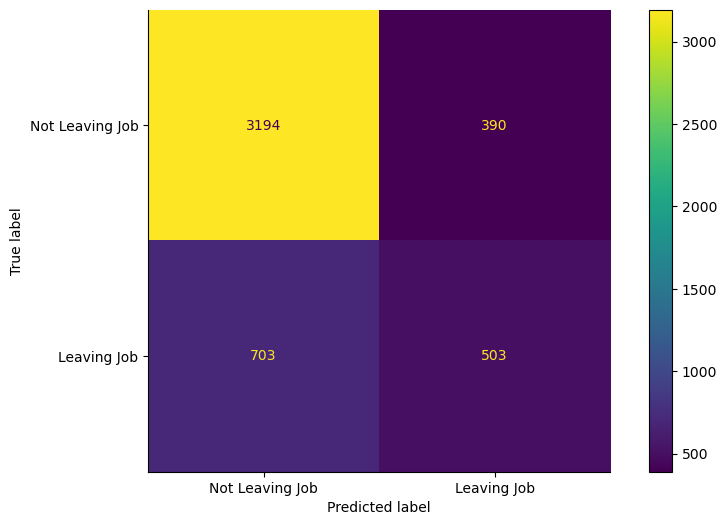

In [73]:
GridSearch = True
if GridSearch == True:
    param_grid = {'max_features': [2,3,4,5], 'max_depth':[3,4,5,6,7,8], 'min_samples_leaf':[8,9,10,11,12,13,14,15,16,17,18],'random_state':[1,42] } 
    dt = DecisionTreeClassifier()
    dt_cv =  GridSearchCV(dt, param_grid)
    dt_cv.fit(X3, y)
    print(dt_cv.best_params_)
    dtpre = dt_cv.predict(X3_test)
    dtcm = confusion_matrix(y_test,dtpre)
    print("Accuracy score : {:.2f}".format(accuracy_score(dtpre,y_test)))
    print("Recall score : {:.2f}".format(recall_score(dtpre,y_test,average='macro',zero_division=True)))
    print("Precision score : {:.2f}".format(precision_score(dtpre,y_test,zero_division = True)))
    print("F1 score : {:.2f}".format(f1_score(dtpre,y_test,zero_division=True)))
    dis = ConfusionMatrixDisplay(dtcm,display_labels=["Not Leaving Job","Leaving Job"])
    dis.plot()
    plt.show()

#### DecisionTreeClassifier / Pipeline 3 with oversampling

{'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 18, 'random_state': 42}
Accuracy score : 0.71
Recall score : 0.68
Precision score : 0.76
F1 score : 0.57


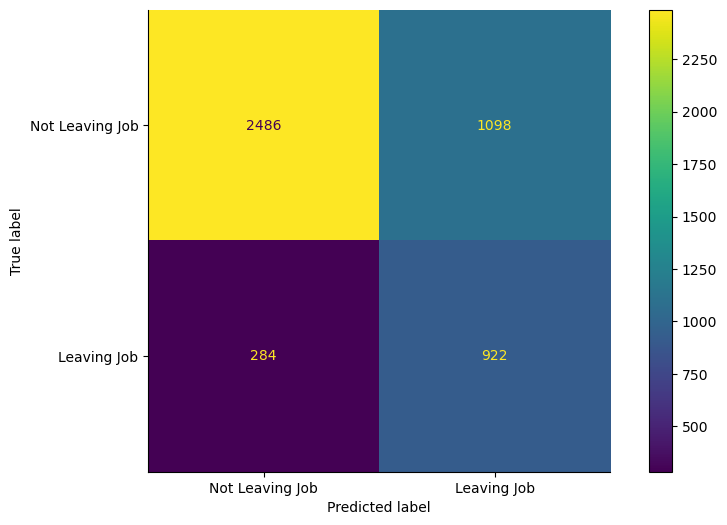

In [74]:
GridSearch = True
if GridSearch == True:
    param_grid =  {'max_features': [2,3,4,5], 'max_depth':[3,4,5,6,7,8], 'min_samples_leaf':[8,9,10,11,12,13,14,15,16,17,18],'random_state':[1,42] } 
    dt = DecisionTreeClassifier()
    dt_cv =  GridSearchCV(dt, param_grid)
    dt_cv.fit(X3_smote, y3_smote)
    print(dt_cv.best_params_)
    dtpre = dt_cv.predict(X3_test)
    dtcm = confusion_matrix(y_test,dtpre)
    print("Accuracy score : {:.2f}".format(accuracy_score(dtpre,y_test)))
    print("Recall score : {:.2f}".format(recall_score(dtpre,y_test,average='macro',zero_division=True)))
    print("Precision score : {:.2f}".format(precision_score(dtpre,y_test,zero_division = True)))
    print("F1 score : {:.2f}".format(f1_score(dtpre,y_test,zero_division=True)))
    dis = ConfusionMatrixDisplay(dtcm,display_labels=["Not Leaving Job","Leaving Job"])
    dis.plot()
    plt.show()